In [14]:
import os
import pandas as pd
import matplotlib.pyplot as plt
#hide
from collections import Counter
from statistics import mean, median, stdev
import numpy as np

from transformers import (
    MODEL_WITH_LM_HEAD_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)


MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

In [15]:
class Args():
    def __init__(self):
        self.output_dir = 'output-small'
        self.model_type = 'gpt2'
        self.model_name_or_path = 'microsoft/DialoGPT-small'
        self.config_name = 'microsoft/DialoGPT-small'
        self.tokenizer_name = 'microsoft/DialoGPT-small'
        self.cache_dir = 'cached'
        self.block_size = 512
        self.do_train = True
        self.do_eval = True
        self.evaluate_during_training = False
        self.per_gpu_train_batch_size = 4
        self.per_gpu_eval_batch_size = 4
        self.gradient_accumulation_steps = 1
        self.learning_rate = 5e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 3
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 1000
        self.save_steps = 3500
        self.save_total_limit = None
        self.eval_all_checkpoints = False
        self.no_cuda = False
        self.overwrite_output_dir = True
        self.overwrite_cache = True
        self.should_continue = False
        self.seed = 42
        self.local_rank = -1
        self.fp16 = False
        self.fp16_opt_level = 'O1'

args = Args()

In [17]:
trn_df = pd.read_csv(r'E:\Data_analysis\NLP_2023.1\NLP.2023.1.Generative-Based-Chatbot\data\train.csv')
trn_df = trn_df.drop(columns='Unnamed: 0')
val_df = pd.read_csv(r'E:\Data_analysis\NLP_2023.1\NLP.2023.1.Generative-Based-Chatbot\data\val.csv')
val_df = val_df.drop(columns='Unnamed: 0')
trn_df.head()

,response,context 4,context 3,context 2,context 1,context 0,disease
0,You're welcome! Let me know if you have any mo...,"Thank you for the information, Medi.","Yes, there are antiviral medications available...",Is there a treatment for hepatitis B?,"Symptoms of hepatitis B can vary, but they may...","Medi, what are the symptoms of hepatitis B?",Hepatitis
1,You're welcome! Let me know if you have any mo...,"Thank you for the explanation, Medi.","Yes, other symptoms can include a loss of posi...",Are there any other symptoms that can accompan...,"Based on your symptoms, it's possible that you...","Hi, Medi. I've been experiencing pins-and-need...",Migraine
2,You're welcome! If you have any further questi...,"Thank you for the advice, Medi.",There are medications available for the acute ...,Is there any way to quickly relieve a migraine...,"Based on your symptoms, it's possible that you...","Hi, Medi. I've been experiencing severe headac...",Migraine
3,You're welcome! It's always best to involve yo...,"Thank you for the information, Medi. I will di...",The dried leaves or dried aerial parts of feve...,That's great to hear. Is there any specific wa...,Feverfew has been traditionally used for heada...,"Hello, Medi. I've been considering using fever...",Migraine
4,You're welcome! I hope these strategies help y...,"Thank you, Medi. I will try implementing these...","Yes, there are several strategies that can hel...",Is there anything I can do to reduce my anxiety?,Anxiety can be caused by various factors such ...,"Medi, I've been feeling really anxious lately....",Mental_illness


In [19]:
print(trn_df.count())
print(val_df.count())

response     6567
context 4    6538
context 3    6544
context 2    6570
context 1    6572
context 0    6572
disease      6572
dtype: int64
response     731
context 4    728
context 3    728
context 2    730
context 1    731
context 0    731
disease      731
dtype: int64


In [20]:
# Count the number of missing values
missing_values_count = trn_df.isna().sum()

# Display the count of missing values
print(missing_values_count)

response      5
context 4    34
context 3    28
context 2     2
context 1     0
context 0     0
disease       0
dtype: int64


In [21]:
trn_df = trn_df.dropna()
val_df = val_df.dropna()
trn_df.count()

response     6535
context 4    6535
context 3    6535
context 2    6535
context 1    6535
context 0    6535
disease      6535
dtype: int64

In [22]:
def get_counter_and_lens(data, tokenizer):
    flatten = lambda l: [item for sublist in l for item in sublist]
    toks = [tokenizer.tokenize(x) for x in data]
    
    return list(map(len, toks)), Counter(flatten(toks)), Counter(' '.join(data).split())

In [23]:
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_path, cache_dir=args.cache_dir)
lens, tok_cnt, word_cnt = get_counter_and_lens(trn_df[df.columns].apply(lambda x: ' '.join(x.astype(str)), axis = 1), tokenizer)

In [24]:
#collapse
def plot_counts(counts, top_k = 30):
    labels, values = zip(*counts.most_common()[:top_k])

    indexes = np.arange(len(labels))
    width = 1
    plt.figure(num=None, figsize=(22, 4), dpi=60, facecolor='w', edgecolor='k')
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

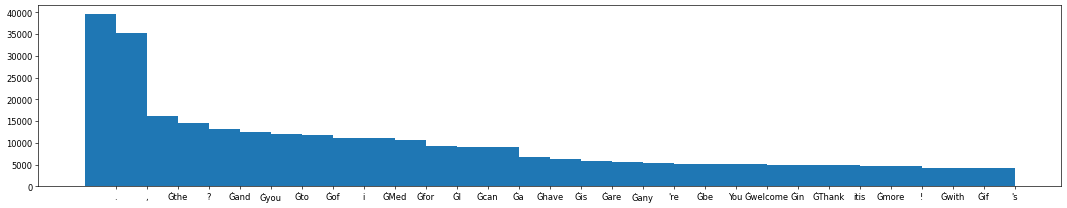

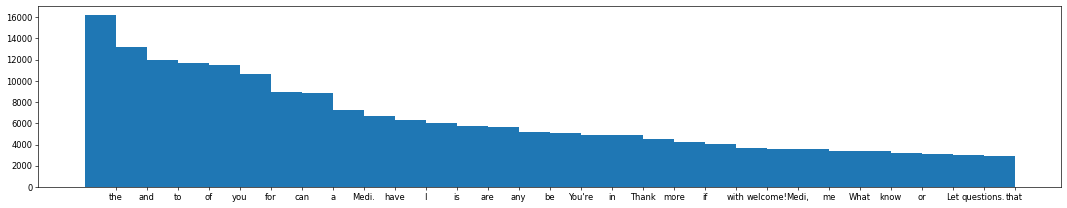

In [25]:
plot_counts(tok_cnt, top_k = 30)
plot_counts(word_cnt, top_k = 30)

In [26]:
#collapse
def plot_hist(lens, n_bins = 50):
    n, bins, patches = plt.hist(lens, n_bins, facecolor='blue', alpha=0.9)
    plt.show()

Mean: 110.97918898240245, Median: 110, Standard Deviation: 18.379852366607988, 90th Percentile: 195.0


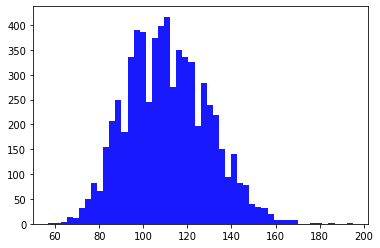

In [27]:
print(f'Mean: {mean(lens)}, Median: {median(lens)}, Standard Deviation: {stdev(lens)}, 90th Percentile: {np.percentile(lens, 100)}')
plot_hist(lens)